# Language Translator

In [205]:
import nltk
import pandas as pd
import numpy as np

import string
import re
from numpy import array, argmax, random, take
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import plot_model

In [206]:
nltk.download('comtrans')

[nltk_data] Downloading package comtrans to
[nltk_data]     /Users/craiglynch/nltk_data...
[nltk_data]   Package comtrans is already up-to-date!


True

In [207]:
from nltk.corpus import comtrans
print(comtrans.aligned_sents('alignment-en-fr.txt')[0])

<AlignedSent: 'Resumption of the se...' -> 'Reprise de la sessio...'>


In [208]:
len(comtrans.aligned_sents('alignment-en-fr.txt'))

33334

### Create and Pre-Process DataFrame

In [209]:
def retrieve_corpora():
    
    corpus = comtrans.aligned_sents('alignment-en-fr.txt')
    eng = [sent.words for sent in corpus]
    fr = [sent.mots for sent in corpus]
    
    return eng, fr
eng, fr = retrieve_corpora()

In [210]:
# Make lowercase
eng = [list(map(str.casefold, x)) for x in eng]
fr = [list(map(str.casefold, x)) for x in fr]

In [211]:
df_fr = pd.Series(fr)
df_fr = pd.DataFrame(df_fr)
df_eng = pd.Series(eng)
df_eng = pd.DataFrame(df_eng)
df_eng.head()

,0
0,"[resumption, of, the, session]"
1,"[i, declare, resumed, the, session, of, the, e..."
2,"[you, have, requested, a, debate, on, this, su..."
3,"[please, rise, ,, then, ,, for, this, minute, ..."
4,"[(, the, house, rose, and, observed, a, minute..."


In [212]:
df_fr = df_fr.rename(columns={df_fr.columns[0]: 'Fr'})
df_fr = df_fr.astype(pd.StringDtype())
df_eng = df_eng.rename(columns={df_eng.columns[0]: 'En'})
df_eng = df_eng.astype(pd.StringDtype())
df_eng.head()

,En
0,"['resumption', 'of', 'the', 'session']"
1,"['i', 'declare', 'resumed', 'the', 'session', ..."
2,"['you', 'have', 'requested', 'a', 'debate', 'o..."
3,"['please', 'rise', ',', 'then', ',', 'for', 't..."
4,"['(', 'the', 'house', 'rose', 'and', 'observed..."


In [213]:
# Remove Punctuation
import string
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

df_eng['En'] = df_eng['En'].apply(remove_punctuations)
df_fr['Fr'] = df_fr['Fr'].apply(remove_punctuations)
df_fr.head()

,Fr
0,reprise de la session
1,je déclare reprise la session du parlement eur...
2,vous avez souhaité un débat à ce sujet dans le...
3,je vous invite à vous lever pour cette minute ...
4,le parlement debout observe une minute de s...


In [214]:
# Combine datasets into 1
df = df_eng.join(df_fr)
df.head()

,En,Fr
0,resumption of the session,reprise de la session
1,i declare resumed the session of the european ...,je déclare reprise la session du parlement eur...
2,you have requested a debate on this subject in...,vous avez souhaité un débat à ce sujet dans le...
3,please rise then for this minute s silence,je vous invite à vous lever pour cette minute ...
4,the house rose and observed a minute s silence,le parlement debout observe une minute de s...


### Text to Sequence Conversion (converts text to tokens)

Visualise the length of the sentences.

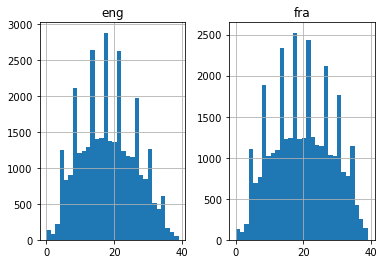

In [215]:
# empty lists
eng_l = []
fra_l = []

# populate the lists with sentence lengths
for i in df['En']:
      eng_l.append(len(i.split()))

for i in df['Fr']:
      fra_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'fra':fra_l})

length_df.hist(bins = 30)
plt.show()

In [217]:
from pickle import load
from pickle import dump
from numpy.random import rand
# reduce dataset size
df = df.head(10000)
# random shuffle
# from numpy.random import shuffle
# shuffle(df)
# split into train/test
train = df.head(8000)
test = df.tail(2000)
# save
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)
    
save_clean_data(df, 'english-french-both.pkl')
save_clean_data(train, 'english-french-train.pkl')
save_clean_data(test, 'english-french-test.pkl')

Saved: english-french-both.pkl
Saved: english-french-train.pkl
Saved: english-french-test.pkl


In [218]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

# load datasets
df = load_clean_sentences('english-french-both.pkl')
train = load_clean_sentences('english-french-train.pkl')
test = load_clean_sentences('english-french-test.pkl')

In [219]:
train.head()

,En,Fr
0,resumption of the session,reprise de la session
1,i declare resumed the session of the european ...,je déclare reprise la session du parlement eur...
2,you have requested a debate on this subject in...,vous avez souhaité un débat à ce sujet dans le...
3,please rise then for this minute s silence,je vous invite à vous lever pour cette minute ...
4,the house rose and observed a minute s silence,le parlement debout observe une minute de s...


In [220]:
df = df[["En", "Fr"]].to_numpy()
train = train[["En", "Fr"]].to_numpy()
test = test[["En", "Fr"]].to_numpy()

In [221]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [222]:
# prepare English tokenizer
eng_tokenizer = create_tokenizer(df[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(df[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare French tokenizer
fra_tokenizer = create_tokenizer(df[:, 1])
fra_vocab_size = len(fra_tokenizer.word_index) + 1
fra_length = max_length(df[:, 1])
print('French Vocabulary Size: %d' % fra_vocab_size)
print('French Max Length: %d' % (fra_length))

English Vocabulary Size: 9496
English Max Length: 39
French Vocabulary Size: 12549
French Max Length: 39


Max length of sentences for both English and French is 38

Function to prepare the sequences. It will also perform sequence padding to a maximum sentence length

In [223]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
     # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
     # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Model Building

Define Seq2Seq model architecture:

* Encoder: use an embedding layer and an LSTM layer
* Decoder: use LSTM layer followed by a dense layer

In [224]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(df, test_size=0.2, random_state = 12)

In [225]:
# prepare training data
trainX = encode_sequences(fra_tokenizer, fra_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(fra_tokenizer, fra_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [226]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(8000, 39)
(8000, 39)
(2000, 39)
(2000, 39)


In [227]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [228]:
# model compilation
model = define_model(fra_vocab_size, eng_vocab_size, fra_length, eng_length, 512)

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 39, 512)           6425088   
_________________________________________________________________
lstm_10 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 39, 512)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 39, 512)           2099200   
_________________________________________________________________
dense_5 (Dense)              (None, 39, 9496)          4871448   
Total params: 15,494,936
Trainable params: 15,494,936
Non-trainable params: 0
_________________________________________________________________
None


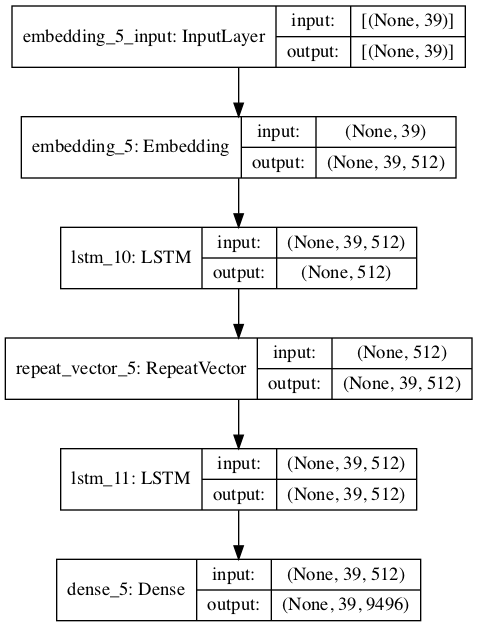

In [229]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

### Training the Model

In [230]:
# Epoch 30, batch_size 64

In [231]:
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=20, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/20
13/13 [==============================] - 222s 16s/step - loss: 4.9356 - val_loss: 3.7171

Epoch 00001: val_loss improved from inf to 3.71708, saving model to model.h5
Epoch 2/20
13/13 [==============================] - 195s 15s/step - loss: 3.6329 - val_loss: 3.6431

Epoch 00002: val_loss improved from 3.71708 to 3.64309, saving model to model.h5
Epoch 3/20
13/13 [==============================] - 197s 15s/step - loss: 3.5483 - val_loss: 3.6272

Epoch 00003: val_loss improved from 3.64309 to 3.62722, saving model to model.h5
Epoch 4/20
13/13 [==============================] - 202s 15s/step - loss: 3.4892 - val_loss: 3.5871

Epoch 00004: val_loss improved from 3.62722 to 3.58707, saving model to model.h5
Epoch 5/20
13/13 [==============================] - 195s 15s/step - loss: 3.4158 - val_loss: 3.4944

Epoch 00005: val_loss improved from 3.58707 to 3.49438, saving model to model.h5
Epoch 6/20
13/13 [==============================] - 194s 15s/step - loss: 3.3789 - val_loss: 3

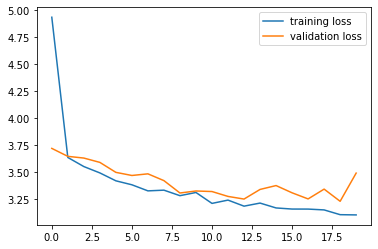

In [242]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.show()

# Evaluate the Model

In [233]:
model = load_model('model.h5')

translation = model.predict(testX, verbose=0)
#preds = model.predict_classes(testX)

In [234]:
translation.shape

(2000, 39, 9496)

In [235]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [236]:
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

In [237]:
from nltk.translate.bleu_score import corpus_bleu
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [238]:
# load model
model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[madame la présidente  je voudrais tout simplement inviter mon collègue wurtz à relire et à vérifier de quoi il s  agit ], target=[madam president  i should simply like to ask mr wurtz to take a second look at what this is about ], predicted=[i is the the the the the the the the the the the the]
src=[trop souvent on appelle ce genre de structure une fois le drame survenu ], target=[all too often we find ourselves calling for this after a disaster has occurred ], predicted=[i is the the the the the the the the]
src=[des réponses manquent encore ], target=[answers are still awaited ], predicted=[the is]
src=[je suis même surpris qu  elle soit faite  parce que nous nous étions mis d  accord làdessus après un échange en conférence des présidents ], target=[i am surprised it has even been made  because we came to an agreement following an exchange in the conference of presidents ], predicted=[i is the the the the the the the the the the the the the the]
src=[vous pouvez donc diffi

/opt/anaconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/anaconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.093951
BLEU-2: 0.011952
BLEU-3: 0.000000
BLEU-4: 0.000000
test
src=[l europe sociale  utilisée comme fairevaloir par l ue  a carrément disparu de l ordre du jour ], target=[social europe  used as a foil by the eu  has simply been eliminated from the agenda ], predicted=[i is the the the the the the the the the]
src=[je suis également convaincue que life a un potentiel énorme ], target=[i am also convinced that life has great potential ], predicted=[i is the the the the the]
src=[le rétablissement récent de certains contrôles aux frontières intérieures me pousse à conclure qu il est nécessaire de procéder à une analyse détaillée des conditions d adoption d un instrument législatif fondé sur l article 62 du traité ], target=[the recent restoring of certain internal border controls leads me to believe that we need a detailed analysis of the conditions for adopting a legislative instrument based on article 62 of the treaty ], predicted=[i is the the the the the the the the the th